In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
pd.set_option('display.max_rows', 8)
!date

%load_ext autoreload
%autoreload 2

Tue Mar 30 06:38:47 PDT 2021


# Consistent LSFF baseline parameters

When regression comes up with inconsistent values for baseline parameters, what do we do with them?  One idea is to make them consistent.  There is a Bayeian interpretation of this---we have estimated the parameters independently as priors, and now we are bringing them together with consistency logic to derive a posterior. Computationally, I will attempt this with "Von Neumann rejection sampling".

In [4]:
a_mean = 22.5  # percent fortified
b_mean = 5.6 # percent fortifiable

# problem: means predicted by regression model are inconsistent

In [18]:
# possible solution: use uncertainty--- we are very unsure about these means
n_draws = 10_000
def my_draws(rng, mu, precision):
    a = mu/100
    b = 1 - a
    return 100*rng.beta(a*precision, b*precision, size=n_draws)

rng = np.random.default_rng(12345)
a_draws = my_draws(rng, a_mean, 10)
b_draws = my_draws(rng, b_mean, 10)

In [19]:
def my_describe(x):
    return pd.Series(x).describe(percentiles=[.025, .975]).loc[['mean', '2.5%', '97.5%']]
my_describe(a_draws)

mean     22.482671
2.5%      3.707152
97.5%    51.229623
dtype: float64

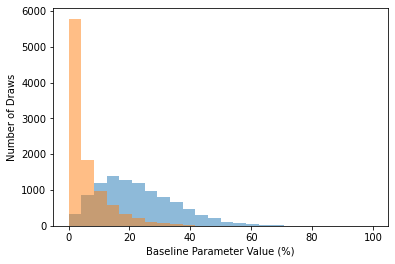

In [21]:
def my_hist(x):
    plt.hist(x, bins=np.linspace(0,100,25), alpha=.5)
    plt.xlabel('Baseline Parameter Value (%)')
    plt.ylabel('Number of Draws')
my_hist(a_draws)
my_hist(b_draws)

In [23]:
def my_filter(a, b):
    df = pd.DataFrame({'a':a, 'b':b})
    consistent_rows = (df.a <= df.b)
    return df.loc[consistent_rows]
df_consistent = my_filter(a_draws, b_draws)

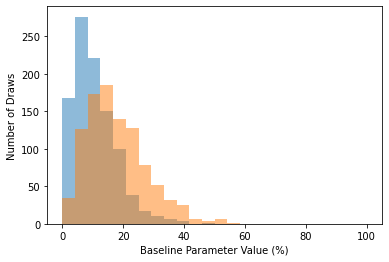

In [24]:
my_hist(df_consistent.a)
my_hist(df_consistent.b)

In [25]:
my_describe(df_consistent.a)

mean     10.591977
2.5%      1.331095
97.5%    28.119391
Name: a, dtype: float64

In [26]:
my_describe(df_consistent.b)

mean     17.790220
2.5%      3.660993
97.5%    39.233075
Name: b, dtype: float64

We could try to get % consumed to be consistent, too, but it will require more rejections and is not required for our calculations (I think)